# 🏠 House Price Prediction with PyTorch Deep Learning
## Week 3 Assignment - MLP (Multi-Layer Perceptron)

**Hedef:** Ev özelliklerinden fiyat tahmini yapan bir Neural Network modeli geliştirmek

**Veri Seti:** Kaggle House Prices (80+ özellik, 1460 ev)

**Model:** PyTorch MLP (Multi-Layer Perceptron)

**Değerlendirme:** RMSE (Root Mean Squared Error)

---

### 🎯 Proje Adımları:
1. ✅ Kütüphaneleri yükle ve PyTorch'u kur
2. ✅ Veriyi yükle ve incele
3. ✅ Preprocessing (missing values, encoding, scaling)
4. ✅ Train-Validation split
5. 🆕 PyTorch Dataset & DataLoader oluştur
6. 🆕 MLP Neural Network mimarisi tanımla
7. 🆕 Training loop ile modeli eğit
8. ✅ RMSE hesapla ve değerlendir
9. ✅ Test setine tahmin yap ve Kaggle'a gönder

---

In [1]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn araçları (preprocessing için)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# PyTorch kütüphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# GPU kullanılabilir mi kontrol et
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*60)
print("🔧 KÜTÜPHANELER YÜKLENDİ")
print("="*60)
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Pandas version: {pd.__version__}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device (CPU/GPU): {device}")
print("="*60)

🔧 KÜTÜPHANELER YÜKLENDİ
✅ NumPy version: 2.0.2
✅ Pandas version: 2.2.2
✅ PyTorch version: 2.9.0+cpu
✅ Device (CPU/GPU): cpu


### 📚 **Yüklenen Kütüphaneler Açıklaması:**

**Temel Veri İşleme:**
- `numpy`, `pandas` → Veri manipülasyonu
- `matplotlib`, `seaborn` → Görselleştirme

**Sklearn (Preprocessing için):**
- `train_test_split` → Veriyi train-validation'a böler
- `StandardScaler` → Sayısal verileri normalize eder (mean=0, std=1)
- `LabelEncoder` → Kategorik değişkenleri sayıya çevirir
- `SimpleImputer` → Eksik değerleri doldurur
- `mean_squared_error` → RMSE hesaplamak için

**PyTorch (Deep Learning):**
- `torch` → PyTorch'un ana kütüphanesi
- `torch.nn` → Neural Network katmanları (Linear, ReLU, Dropout vb.)
- `torch.optim` → Optimizer'lar (Adam, SGD)
- `DataLoader` → Veriyi batch'ler halinde modele verir

**Device:** GPU varsa kullan, yoksa CPU (Google Colab'da genelde CPU)

---

In [2]:
print("="*60)
print("📦 VERİ YÜKLEME")
print("="*60)

# Veri setlerini oku
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"✅ Train shape: {train.shape}")
print(f"✅ Test shape: {test.shape}")

# İlk 3 satırı göster
print("\n📋 Train ilk 3 satır:")
print(train.head(3))

# Veri tipleri
print("\n📊 Veri Tipleri Dağılımı:")
print(f"   Sayısal (numeric): {train.select_dtypes(include=[np.number]).shape[1]} sütun")
print(f"   Kategorik (object): {train.select_dtypes(include=['object']).shape[1]} sütun")

print("="*60)

📦 VERİ YÜKLEME
✅ Train shape: (1460, 81)
✅ Test shape: (1459, 80)

📋 Train ilk 3 satır:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]

📊 Veri Tipleri Dağılımı:
   Sayısal (numeric): 38 sütun
   Kategorik (object):

### 📦 **Veri Seti Hakkında:**

**Train:** 1460 ev, 81 sütun (80 özellik + 1 hedef değişken)
**Test:** 1459 ev, 80 sütun (SalePrice yok)

**Sayısal Özellikler:** Alan (sqft), yaş, oda sayısı gibi
**Kategorik Özellikler:** Mahalle, ev tipi, kalite puanları gibi

**Hedef Değişken:** `SalePrice` (tahmin edeceğimiz fiyat)

---

In [3]:
print("="*60)
print("🎯 HEDEF DEĞİŞKENİ AYIRMA")
print("="*60)

# Train'den SalePrice'ı ayır
y = train['SalePrice'].copy()
train_features = train.drop(['Id', 'SalePrice'], axis=1)

# Test'ten Id'yi ayır
test_ids = test['Id'].copy()
test_features = test.drop(['Id'], axis=1)

print(f"✅ X (features) shape: {train_features.shape}")
print(f"✅ y (target) shape: {y.shape}")
print(f"✅ Test features shape: {test_features.shape}")

# Target dağılımı
print(f"\n📊 SalePrice İstatistikleri:")
print(f"   Ortalama: ${y.mean():,.2f}")
print(f"   Median: ${y.median():,.2f}")
print(f"   Min: ${y.min():,.2f}")
print(f"   Max: ${y.max():,.2f}")

print("="*60)

🎯 HEDEF DEĞİŞKENİ AYIRMA
✅ X (features) shape: (1460, 79)
✅ y (target) shape: (1460,)
✅ Test features shape: (1459, 79)

📊 SalePrice İstatistikleri:
   Ortalama: $180,921.20
   Median: $163,000.00
   Min: $34,900.00
   Max: $755,000.00


### 🎯 **Hedef Değişken Ayrıldı:**

`Id` → Test tahminlerinde kullanmak için sakladık  
`SalePrice` → Bu değeri tahmin edeceğiz  
`X (features)` → Modelin girdi alacağı özellikler

**Not:** Neural Network'ler sayısal veri bekler, bu yüzden kategorik değişkenleri sayıya çevireceğiz.

---

In [4]:
print("="*60)
print("❌ EKSİK DEĞER ANALİZİ")
print("="*60)

# Train'deki eksik değerler
missing_train = train_features.isnull().sum()
missing_train_pct = (missing_train / len(train_features)) * 100

# Sadece eksik olanları göster
missing_df = pd.DataFrame({
    'Column': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Pct': missing_train_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"\n📊 Eksik Değer İçeren Sütun Sayısı: {len(missing_df)}")
print("\nİlk 10 sütun:")
print(missing_df.head(10).to_string(index=False))

print("="*60)

❌ EKSİK DEĞER ANALİZİ

📊 Eksik Değer İçeren Sütun Sayısı: 19

İlk 10 sütun:
      Column  Missing_Count  Missing_Pct
      PoolQC           1453    99.520548
 MiscFeature           1406    96.301370
       Alley           1369    93.767123
       Fence           1179    80.753425
  MasVnrType            872    59.726027
 FireplaceQu            690    47.260274
 LotFrontage            259    17.739726
  GarageType             81     5.547945
 GarageYrBlt             81     5.547945
GarageFinish             81     5.547945


---
## 📚 **KONU: Data Preprocessing (Veri Ön İşleme)**

Neural Network'lere veri vermeden önce **3 önemli işlem** yapmalıyız:

### **1. Missing Values (Eksik Değerleri) Doldurma:**

**Neden?**
- Neural Network NaN değerleri işleyemez
- Model eğitimi sırasında hata verir

**Stratejiler:**
- **Sayısal:** Median ile doldur (outlier'lardan etkilenmez)
- **Kategorik:** Most frequent (en sık) veya "Missing" ile doldur
```python
# Örnek
imputer = SimpleImputer(strategy='median')
X_numeric = imputer.fit_transform(X_numeric)
```

---

### **2. Categorical Encoding (Kategorik Değişkenleri Sayıya Çevirme):**

**Neden?**
- Neural Network sadece sayılarla çalışır
- "RL", "RM" gibi metinleri anlayamaz

**Yöntemler:**

**A) Label Encoding:** Her kategori bir sayı alır
```python
"RL" → 0
"RM" → 1
"FV" → 2
```

**B) One-Hot Encoding:** Her kategori binary sütun olur
```python
     RL  RM  FV
0    1   0   0
1    0   1   0
2    0   0   1
```

**Bu projede:** Label Encoding kullanacağız (daha basit, daha az özellik)

---

### **3. Feature Scaling (Özellik Ölçeklendirme):**

**Neden?**
- Farklı ölçeklerdeki özellikler modeli yanıltır
- Örnek: `LotArea` (0-200,000) vs `BedroomAbvGr` (0-10)
- Büyük sayılar gradient'leri bozar

**StandardScaler:**
```python
scaled_value = (value - mean) / std
```

**Sonuç:** Her özellik mean=0, std=1 olur

**Örnek:**
```
LotArea: [8450, 9600, 11250]
Mean: 9766.67
Std: 1150.23

Scaled: [-1.14, -0.14, 1.28]
```

---

### ❌ **Eksik Değer Stratejisi:**

**Sayısal Sütunlar:** Median ile doldur  
**Kategorik Sütunlar:** "Missing" veya most_frequent ile doldur

**Neden önemli?**  
Neural Network'ler NaN (eksik) değerleri işleyemez, bu yüzden doldurmalıyız.

---

In [5]:
print("="*60)
print("🔍 SAYISAL VE KATEGORİK SÜTUNLARI AYIR")
print("="*60)

# Sayısal ve kategorik sütunları belirle
numeric_cols = train_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_features.select_dtypes(include=['object']).columns.tolist()

print(f"✅ Sayısal sütun sayısı: {len(numeric_cols)}")
print(f"✅ Kategorik sütun sayısı: {len(categorical_cols)}")

print(f"\nİlk 5 sayısal sütun: {numeric_cols[:5]}")
print(f"İlk 5 kategorik sütun: {categorical_cols[:5]}")

print("="*60)

🔍 SAYISAL VE KATEGORİK SÜTUNLARI AYIR
✅ Sayısal sütun sayısı: 36
✅ Kategorik sütun sayısı: 43

İlk 5 sayısal sütun: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']
İlk 5 kategorik sütun: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']


### 🔍 **Sayısal vs Kategorik - Neden Ayırdık?**

**Farklı işlem gerektiriyorlar:**

**Sayısal Sütunlar:**
- Zaten sayı formatında (37, 1500, 2003 gibi)
- İşlem: Eksik değer doldur → Scale et
- Örnek: `LotArea`, `YearBuilt`, `GrLivArea`

**Kategorik Sütunlar:**
- Metin formatında ("RL", "Gable", "Ex" gibi)
- İşlem: Eksik değer doldur → Sayıya çevir (Label Encoding)
- Örnek: `MSZoning`, `Neighborhood`, `RoofStyle`

**select_dtypes() fonksiyonu:**
- `include=[np.number]` → int64, float64 tipindeki sütunları seç
- `include=['object']` → string/text tipindeki sütunları seç

**Sonraki adım:** Her iki tip için ayrı preprocessing yapacağız

---

In [6]:
print("="*60)
print("🔧 EKSİK DEĞERLERİ DOLDUR - SAYISAL")
print("="*60)

# Sayısal sütunlar için SimpleImputer (median stratejisi)
numeric_imputer = SimpleImputer(strategy='median')

# Train verisi
train_numeric = train_features[numeric_cols].copy()
train_numeric_filled = pd.DataFrame(
    numeric_imputer.fit_transform(train_numeric),
    columns=numeric_cols,
    index=train_numeric.index
)

# Test verisi (aynı imputer ile)
test_numeric = test_features[numeric_cols].copy()
test_numeric_filled = pd.DataFrame(
    numeric_imputer.transform(test_numeric),
    columns=numeric_cols,
    index=test_numeric.index
)

print(f"✅ Sayısal eksik değerler dolduruldu")
print(f"   Train'de kalan eksik: {train_numeric_filled.isnull().sum().sum()}")
print(f"   Test'te kalan eksik: {test_numeric_filled.isnull().sum().sum()}")

print("="*60)

🔧 EKSİK DEĞERLERİ DOLDUR - SAYISAL
✅ Sayısal eksik değerler dolduruldu
   Train'de kalan eksik: 0
   Test'te kalan eksik: 0


### 🔧 **SimpleImputer - Sayısal Eksik Değer Doldurma**

**Ne yaptık?**

**1. SimpleImputer oluşturduk:**
```python
numeric_imputer = SimpleImputer(strategy='median')
```
- `strategy='median'` → Eksik değerleri sütunun median'ı ile doldur
- **Neden median?** Outlier'lardan etkilenmez (mean'den daha güvenli)

**2. fit_transform() - Train verisi:**
```python
numeric_imputer.fit_transform(train_numeric)
```
- **fit:** Her sütunun median'ını öğren ve sakla
- **transform:** Eksik değerleri bu median ile doldur

**3. transform() - Test verisi:**
```python
numeric_imputer.transform(test_numeric)
```
- **Sadece transform:** Train'den öğrenilen median'ları kullan
- **Neden fit yok?** Test, train'den farklı istatistikler kullanmamalı (data leakage önleme)

**Örnek:**
```
LotFrontage sütunu:
Train median = 69.0

Eksik değer → 69.0 ile doldur
```

**Sonuç:** 0 eksik değer kaldı ✅

---

In [7]:
print("="*60)
print("🔧 EKSİK DEĞERLERİ DOLDUR - KATEGORİK")
print("="*60)

# Kategorik sütunlar için SimpleImputer (most_frequent stratejisi)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Train verisi
train_categorical = train_features[categorical_cols].copy()
train_categorical_filled = pd.DataFrame(
    categorical_imputer.fit_transform(train_categorical),
    columns=categorical_cols,
    index=train_categorical.index
)

# Test verisi
test_categorical = test_features[categorical_cols].copy()
test_categorical_filled = pd.DataFrame(
    categorical_imputer.transform(test_categorical),
    columns=categorical_cols,
    index=test_categorical.index
)

print(f"✅ Kategorik eksik değerler dolduruldu")
print(f"   Train'de kalan eksik: {train_categorical_filled.isnull().sum().sum()}")
print(f"   Test'te kalan eksik: {test_categorical_filled.isnull().sum().sum()}")

print("="*60)

🔧 EKSİK DEĞERLERİ DOLDUR - KATEGORİK
✅ Kategorik eksik değerler dolduruldu
   Train'de kalan eksik: 0
   Test'te kalan eksik: 0


print("="*60)
print("🔧 EKSİK DEĞERLERİ DOLDUR - KATEGORİK")
print("="*60)

# Kategorik sütunlar için SimpleImputer (most_frequent stratejisi)
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Train verisi
train_categorical = train_features[categorical_cols].copy()
train_categorical_filled = pd.DataFrame(
    categorical_imputer.fit_transform(train_categorical),
    columns=categorical_cols,
    index=train_categorical.index
)

# Test verisi
test_categorical = test_features[categorical_cols].copy()
test_categorical_filled = pd.DataFrame(
    categorical_imputer.transform(test_categorical),
    columns=categorical_cols,
    index=test_categorical.index
)

print(f"✅ Kategorik eksik değerler dolduruldu")
print(f"   Train'de kalan eksik: {train_categorical_filled.isnull().sum().sum()}")
print(f"   Test'te kalan eksik: {test_categorical_filled.isnull().sum().sum()}")

print("="*60)

In [8]:
print("="*60)
print("🔢 KATEGORİK DEĞİŞKENLERİ LABEL ENCODING")
print("="*60)

# Her kategorik sütun için ayrı LabelEncoder
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()

    # Train ve test'i birleştir (aynı encoding için)
    combined = pd.concat([train_categorical_filled[col], test_categorical_filled[col]], axis=0)
    le.fit(combined)

    # Transform
    train_categorical_filled[col] = le.transform(train_categorical_filled[col])
    test_categorical_filled[col] = le.transform(test_categorical_filled[col])

    label_encoders[col] = le

print(f"✅ {len(categorical_cols)} kategorik sütun encode edildi")
print(f"\nÖrnek: MSZoning")
print(f"   Unique values: {len(label_encoders['MSZoning'].classes_)}")
print(f"   Classes: {label_encoders['MSZoning'].classes_}")

print("="*60)

🔢 KATEGORİK DEĞİŞKENLERİ LABEL ENCODING
✅ 43 kategorik sütun encode edildi

Örnek: MSZoning
   Unique values: 5
   Classes: ['C (all)' 'FV' 'RH' 'RL' 'RM']


### 🔢 **Label Encoding - Kategorik → Sayısal Dönüşüm**

**Ne yaptık?**

**Label Encoding:**
Her benzersiz kategori bir sayı alır.

**Örnek: MSZoning**
```
Orijinal:  ["RL", "RM", "RL", "FV", "RL"]
Encoded:   [  2,    3,    2,    0,    2]

Mapping:
"FV" → 0
"RH" → 1
"RL" → 2
"RM" → 3
```

**Neden train ve test'i birleştirdik?**
```python
combined = pd.concat([train_categorical_filled[col], test_categorical_filled[col]])
le.fit(combined)
```

**Sebep:** Test setinde train'de olmayan bir kategori olabilir
- Eğer sadece train ile fit edersek → Test'te hata verir
- Birleştirip fit edersek → Her iki setteki tüm kategorileri öğrenir

**fit() vs transform():**
- **fit():** Tüm benzersiz değerleri öğren ve mapping oluştur
- **transform():** Mapping'e göre dönüştür

**Saklanması:**
```python
label_encoders[col] = le
```
- İleride tersine çevirmek istersek kullanabiliriz
- Örnek: Tahmin edilen evlerin özelliklerini okumak

**Sonuç:** Tüm kategorik veriler sayıya dönüştü ✅

---

In [9]:
print("="*60)
print("🔗 SAYISAL VE KATEGORİK ÖZELLİKLERİ BİRLEŞTİR")
print("="*60)

# Train: Sayısal + Kategorik (encode edilmiş)
X_train_combined = pd.concat([train_numeric_filled, train_categorical_filled], axis=1)

# Test: Sayısal + Kategorik (encode edilmiş)
X_test_combined = pd.concat([test_numeric_filled, test_categorical_filled], axis=1)

print(f"✅ Train features shape: {X_train_combined.shape}")
print(f"✅ Test features shape: {X_test_combined.shape}")

# Kontrol: Eksik değer kalmadı mı?
print(f"\nEksik değer kontrolü:")
print(f"   Train: {X_train_combined.isnull().sum().sum()}")
print(f"   Test: {X_test_combined.isnull().sum().sum()}")

print("="*60)

🔗 SAYISAL VE KATEGORİK ÖZELLİKLERİ BİRLEŞTİR
✅ Train features shape: (1460, 79)
✅ Test features shape: (1459, 79)

Eksik değer kontrolü:
   Train: 0
   Test: 0


### 🔗 **Özellikleri Birleştirme - Neden?**

**Ne yaptık?**

Sayısal ve kategorik özellikleri yan yana birleştirdik:
```
train_numeric_filled (37 sütun)  +  train_categorical_filled (43 sütun)
        ↓
X_train_combined (80 sütun)
```

**pd.concat() fonksiyonu:**
```python
pd.concat([df1, df2], axis=1)
```
- `axis=1` → Sütun bazında birleştir (yan yana)
- `axis=0` → Satır bazında birleştir (alt alta)

**Neden birleştirdik?**
- Neural Network tek bir input matrix bekler
- Ayrı ayrı sayısal/kategorik veremeyiz
- Hepsi bir arada olmalı

**Final kontrol:**
```
Train: (1460, 80) ✅
Test: (1459, 80) ✅
Eksik değer: 0 ✅
```

**Sonraki adım:** Scaling (ölçeklendirme)

---

In [10]:
print("="*60)
print("📏 FEATURE SCALING (STANDARDSCALER)")
print("="*60)

# StandardScaler oluştur
scaler = StandardScaler()

# Train verisi ile fit ve transform
X_train_scaled = scaler.fit_transform(X_train_combined)

# Test verisi ile sadece transform (train'in mean/std kullan)
X_test_scaled = scaler.transform(X_test_combined)

print(f"✅ Scaling tamamlandı")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

# Örnek: İlk özelliğin istatistikleri
print(f"\nÖrnek: İlk özellik (scaled sonrası)")
print(f"   Mean: {X_train_scaled[:, 0].mean():.6f} (~ 0)")
print(f"   Std: {X_train_scaled[:, 0].std():.6f} (~ 1)")

print("="*60)

📏 FEATURE SCALING (STANDARDSCALER)
✅ Scaling tamamlandı
   Train shape: (1460, 79)
   Test shape: (1459, 79)

Örnek: İlk özellik (scaled sonrası)
   Mean: -0.000000 (~ 0)
   Std: 1.000000 (~ 1)


### 📏 **StandardScaler - Feature Scaling**

**Ne yaptık?**

Her özelliği **standartlaştırdık** (normalize ettik).

**Formula:**
```python
scaled_value = (value - mean) / std
```

**Sonuç:** Her özellik için mean=0, std=1

**Örnek:**
```
LotArea (orjinal):
[8450, 9600, 11250, ...]
Mean: 10516.83
Std: 9981.26

LotArea (scaled):
[-0.207, -0.091, 0.073, ...]
Mean: 0.0
Std: 1.0
```

**Neden gerekli?**

**1. Gradient Descent için:**
- Büyük sayılar gradient'leri çok büyütür
- Küçük sayılar gradient'leri çok küçültür
- Sonuç: Eğitim yavaş ve dengesiz

**2. Farklı ölçekler:**
```
LotArea: 0 - 200,000 (çok büyük)
BedroomAbvGr: 0 - 10 (çok küçük)
```
- Model LotArea'ya çok fazla önem verir
- BedroomAbvGr'ı görmezden gelir

**Scaling sonrası:** Tüm özellikler eşit ölçekte (-3 ile +3 arası genelde)

**fit() vs transform():**
- **fit():** Train'in mean ve std'sini öğren
- **transform():** Bu değerleri kullanarak scale et
- **Test:** Train'in mean/std'si kullanılır (kendi mean/std'si değil!)

**Neden test fit yapılmaz?**
- Data leakage önleme
- Test, train'den bağımsız olmalı

---

---
## 📚 **KONU: Train-Validation Split**

**Neden Train-Validation Split?**

### **Problem: Overfitting**
Eğer tüm veriyle eğitirsek, model veriyi "ezberler" ama yeni veride kötü performans gösterir.

### **Çözüm:**
Veriyi 2'ye böl:
- **80% Train:** Model bununla öğrenir
- **20% Validation:** Modelin gerçek performansını ölçeriz
```
Total Data (1460 ev)
    ↓
Train (1168 ev)  →  Model eğitimi
Validation (292 ev)  →  Performans testi
```

### **Veri Setlerinin Rolleri:**

**1. Training Set:**
- Model bu veriyle öğrenir
- Weights (ağırlıklar) bu veriyle güncellenir
- Loss hesaplanır ve backpropagation yapılır

**2. Validation Set:**
- Model bu veriyi **hiç görmedi**
- Eğitim sırasında sadece performans ölçümü için kullanılır
- Overfitting tespiti için kritik

**3. Test Set (Kaggle):**
- SalePrice'ı bilmiyoruz
- Final submission için kullanılır
- Gerçek dünya performansı

### **random_state=42 Neden?**
- Her çalıştırmada aynı split'i garanti eder
- Sonuçları tekrarlanabilir yapar
- 42 bir gelenektir (The Hitchhiker's Guide to the Galaxy'den 😊)

---

In [11]:
print("="*60)
print("✂️ TRAIN-VALIDATION SPLIT")
print("="*60)

# 80-20 split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled,
    y,
    test_size=0.2,
    random_state=42
)

print(f"✅ Split tamamlandı")
print(f"   Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_train_scaled)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_train_scaled)*100:.1f}%)")
print(f"   Feature count: {X_train.shape[1]}")

# Target istatistikleri
print(f"\n📊 Target (SalePrice) İstatistikleri:")
print(f"   Train mean: ${y_train.mean():,.2f}")
print(f"   Validation mean: ${y_val.mean():,.2f}")

print("="*60)

✂️ TRAIN-VALIDATION SPLIT
✅ Split tamamlandı
   Train set: 1168 samples (80.0%)
   Validation set: 292 samples (20.0%)
   Feature count: 79

📊 Target (SalePrice) İstatistikleri:
   Train mean: $181,441.54
   Validation mean: $178,839.81


### ✂️ **Train-Validation Split - Ne Yaptık?**

**train_test_split() fonksiyonu:**
```python
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
```

**Parametreler:**
- `test_size=0.2` → %20'si validation, %80'i train
- `random_state=42` → Rastgeleliği sabit tut

**Sonuç:**
```
X_train: (1168, 80) → Eğitim özellikleri
X_val: (292, 80) → Validation özellikleri
y_train: (1168,) → Eğitim fiyatları
y_val: (292,) → Validation fiyatları
```

**Validation'ın amacı:**
- Her epoch sonunda validation loss hesapla
- Train loss vs Validation loss karşılaştır
- Overfitting varsa erken dur (Early Stopping)

**Örnek overfitting tespiti:**
```
Epoch 10:
  Train Loss: 0.05 (çok düşük) ✅
  Val Loss: 0.25 (yüksek) ❌
  → Overfitting var!
```

---

---
## 📚 **KONU: PyTorch Tensors & DataLoader**

### **Tensor Nedir?**

**Tensor**, PyTorch'un temel veri yapısıdır (NumPy array gibi).

**Boyutlar:**
- **0D Tensor (Scalar):** `tensor(5.0)`
- **1D Tensor (Vector):** `tensor([1, 2, 3])`
- **2D Tensor (Matrix):** `tensor([[1, 2], [3, 4]])`
- **3D+ Tensor:** Resimler, videolar vb.

**NumPy vs PyTorch:**
```python
# NumPy
x_numpy = np.array([1, 2, 3])

# PyTorch
x_tensor = torch.tensor([1, 2, 3])
```

**PyTorch avantajları:**
- GPU desteği
- Automatic differentiation (otomatik türev)
- Neural network operasyonları

---

### **DataLoader Nedir?**

**DataLoader**, veriyi **batch'ler** (küçük gruplar) halinde modele verir.

**Neden batch kullanırız?**

**1. Bellek sorunu:**
- 1460 evin hepsini aynı anda RAM'e alamayız
- Batch'ler halinde işleriz

**2. Gradient güncelleme:**
- Her batch sonunda weights güncellenir
- Daha hızlı öğrenme

**3. Generalization:**
- Her batch farklı → Model daha genel öğrenir

**Örnek:**
```
Total: 1168 ev
Batch size: 32

Batch 1: Ev 0-31
Batch 2: Ev 32-63
...
Batch 37: Ev 1152-1167 (son 16 ev)
```

**Parametreler:**
- `batch_size` → Bir batch'te kaç örnek
- `shuffle=True` → Her epoch'ta karıştır
- `drop_last=False` → Son batch küçük olsa bile kullan

---

In [12]:
print("="*60)
print("🔥 PYTORCH TENSORS'A ÇEVİR")
print("="*60)

# NumPy array'leri PyTorch tensor'larına çevir
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)

print(f"✅ Tensor'lar oluşturuldu")
print(f"   X_train: {X_train_tensor.shape} - dtype: {X_train_tensor.dtype}")
print(f"   X_val: {X_val_tensor.shape} - dtype: {X_val_tensor.dtype}")
print(f"   y_train: {y_train_tensor.shape} - dtype: {y_train_tensor.dtype}")
print(f"   y_val: {y_val_tensor.shape} - dtype: {y_val_tensor.dtype}")

# Device'a gönder (CPU veya GPU)
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

print(f"\n✅ Tensor'lar {device} üzerine taşındı")

print("="*60)

🔥 PYTORCH TENSORS'A ÇEVİR
✅ Tensor'lar oluşturuldu
   X_train: torch.Size([1168, 79]) - dtype: torch.float32
   X_val: torch.Size([292, 79]) - dtype: torch.float32
   y_train: torch.Size([1168, 1]) - dtype: torch.float32
   y_val: torch.Size([292, 1]) - dtype: torch.float32

✅ Tensor'lar cpu üzerine taşındı


### 🔥 **PyTorch Tensors - NumPy'dan Dönüşüm**

**Ne yaptık?**

**1. FloatTensor oluşturma:**
```python
X_train_tensor = torch.FloatTensor(X_train)
```
- NumPy array → PyTorch tensor
- `FloatTensor` → 32-bit float (Neural Network için standart)

**2. y_train reshape:**
```python
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
```
- `y_train.values` → Pandas Series'i NumPy array'e çevir
- `.reshape(-1, 1)` → (1168,) → (1168, 1)
- **Neden?** PyTorch loss fonksiyonları (1168, 1) formatı bekler

**Shape Karşılaştırması:**
```
X_train: (1168, 80) → Her satır 80 özellik
y_train: (1168, 1) → Her satır 1 fiyat
```

**3. Device'a gönderme:**
```python
X_train_tensor = X_train_tensor.to(device)
```
- `device = 'cpu'` veya `'cuda'` (GPU)
- Colab'da genelde CPU
- GPU varsa otomatik kullanılır

**dtype: torch.float32:**
- Neural Network'ler float32 ile çalışır
- float64 (double) gereksiz hassasiyet (yavaş)
- float16 çok az hassasiyet (hatalı sonuçlar)

---

In [13]:
print("="*60)
print("📦 DATALOADER OLUŞTUR")
print("="*60)

# Batch size belirle
batch_size = 32

# TensorDataset oluştur (X ve y'yi birleştir)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# DataLoader oluştur
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Her epoch'ta karıştır
    drop_last=False  # Son batch'i de kullan
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Validation karıştırılmaz
    drop_last=False
)

print(f"✅ DataLoader'lar oluşturuldu")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

# İlk batch'i kontrol et
for X_batch, y_batch in train_loader:
    print(f"\n📋 İlk batch:")
    print(f"   X shape: {X_batch.shape}")
    print(f"   y shape: {y_batch.shape}")
    break

print("="*60)

📦 DATALOADER OLUŞTUR
✅ DataLoader'lar oluşturuldu
   Batch size: 32
   Train batches: 37
   Validation batches: 10

📋 İlk batch:
   X shape: torch.Size([32, 79])
   y shape: torch.Size([32, 1])


### 📦 **DataLoader - Batch İşleme**

**Ne yaptık?**

**1. TensorDataset:**
```python
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
```
- X ve y'yi birleştirir
- DataLoader bundan batch çeker

**2. DataLoader:**
```python
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
```

**Parametreler:**
- `batch_size=32` → Her batch 32 ev
- `shuffle=True` → Her epoch karıştır (train için)
- `shuffle=False` → Karıştırma (validation için)
- `drop_last=False` → Son batch küçük de olsa kullan

**Batch sayısı hesaplama:**
```
Train: 1168 ev / 32 = 36.5 → 37 batch
  - İlk 36 batch: 32 ev
  - Son batch: 16 ev (1168 - 36*32 = 16)
```

**Kullanım:**
```python
for X_batch, y_batch in train_loader:
    # X_batch: (32, 80) → 32 ev, 80 özellik
    # y_batch: (32, 1) → 32 fiyat
    output = model(X_batch)
    loss = criterion(output, y_batch)
```

**Neden shuffle=True (train)?**
- Her epoch farklı sırayla verir
- Model aynı sırayı ezberlemesin

**Neden shuffle=False (validation)?**
- Performans ölçümü için sıra önemli değil
- Hız kazancı (karıştırma işlemi yok)

---

---
## 📚 **KONU: Neural Network Mimarisi (MLP)**

### **MLP (Multi-Layer Perceptron) Nedir?**

**En basit Neural Network tipidir.**

**Yapısı:**
```
Input → Linear → ReLU → Linear → ReLU → Linear → Output
```

**Katmanlar:**

**1. Linear (Fully Connected) Layer:**
```python
nn.Linear(in_features, out_features)
```
- Her input nöron, her output nörona bağlıdır
- Matematiksel: `y = Wx + b`
  - `W` → Weights (ağırlıklar)
  - `b` → Bias (sapma)

**Örnek:**
```python
layer = nn.Linear(80, 128)
# 80 input → 128 output
# Parameters: 80*128 + 128 = 10,368
```

**2. Activation Function (ReLU):**
```python
nn.ReLU()
```
- Non-linearity ekler
- `ReLU(x) = max(0, x)`
- Negatif → 0, Pozitif → Olduğu gibi

**Neden ReLU?**
- Basit ve hızlı
- Gradient vanishing problemini çözer
- En yaygın aktivasyon fonksiyonu

**3. Dropout (Opsiyonel):**
```python
nn.Dropout(p=0.2)
```
- Rastgele %20 nöron kapatır
- Overfitting'i önler
- Sadece training'de aktif

---

### **Bizim Mimarimiz:**
```
Input (80)
  ↓
Linear(80 → 128)
  ↓
ReLU
  ↓
Dropout(0.2)
  ↓
Linear(128 → 64)
  ↓
ReLU
  ↓
Dropout(0.2)
  ↓
Linear(64 → 32)
  ↓
ReLU
  ↓
Linear(32 → 1)
  ↓
Output (SalePrice)
```

**Neden bu mimari?**
- **128 → 64 → 32:** Progressively azalan (bilgi sıkıştırma)
- **4 katman:** Yeterince derin (karmaşık pattern'ler)
- **Dropout:** Overfitting önleme

---

In [14]:
print("="*60)
print("🧠 MLP MODEL TANIMLAMA")
print("="*60)

# MLP Model sınıfı
class HousePriceMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super(HousePriceMLP, self).__init__()

        # Layer 1: Input → Hidden1
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        # Layer 2: Hidden1 → Hidden2
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # Layer 3: Hidden2 → Hidden3
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()

        # Layer 4: Hidden3 → Output
        self.fc4 = nn.Linear(hidden_sizes[2], 1)

    def forward(self, x):
        # Forward pass
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)

        x = self.fc4(x)
        return x

# Model oluştur
input_size = X_train.shape[1]  # 80
hidden_sizes = [128, 64, 32]
dropout_rate = 0.2

model = HousePriceMLP(input_size, hidden_sizes, dropout_rate)
model = model.to(device)

print(f"✅ Model oluşturuldu")
print(f"   Input size: {input_size}")
print(f"   Hidden sizes: {hidden_sizes}")
print(f"   Dropout rate: {dropout_rate}")
print(f"   Device: {device}")

# Model özeti
print(f"\n📊 Model Parametreleri:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

print("\n🏗️ Model Mimarisi:")
print(model)

print("="*60)

🧠 MLP MODEL TANIMLAMA
✅ Model oluşturuldu
   Input size: 79
   Hidden sizes: [128, 64, 32]
   Dropout rate: 0.2
   Device: cpu

📊 Model Parametreleri:
   Total parameters: 20,609
   Trainable parameters: 20,609

🏗️ Model Mimarisi:
HousePriceMLP(
  (fc1): Linear(in_features=79, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


### 🧠 **MLP Model - Kod Açıklaması**

**nn.Module sınıfı:**
```python
class HousePriceMLP(nn.Module):
    def __init__(self, ...):
        super(HousePriceMLP, self).__init__()
```
- Tüm PyTorch modelleri `nn.Module`'den türetilir
- `super().__init__()` → Parent class'ı başlat

**__init__() metodu:**
- Katmanları tanımla
- Bu katmanlar eğitim sırasında kullanılacak

**forward() metodu:**
- İleri yönlü hesaplama
- Input → Output akışı
- PyTorch otomatik backward (geriye) hesaplar

**Katman tanımlama:**
```python
self.fc1 = nn.Linear(80, 128)
```
- `fc` → Fully Connected
- `80 → 128` → 80 input, 128 output

**Forward pass:**
```python
def forward(self, x):
    x = self.fc1(x)  # Linear transformation
    x = self.relu1(x)  # Activation
    x = self.dropout1(x)  # Regularization
    ...
```

**Hesaplama örneği:**
```
Input: (batch_size, 80)
  ↓ fc1
(batch_size, 128)
  ↓ relu1
(batch_size, 128)
  ↓ dropout1
(batch_size, 128)
  ↓ fc2
(batch_size, 64)
  ...
  ↓ fc4
(batch_size, 1) → Output
```

**Parametre sayısı:**
```
fc1: 80*128 + 128 = 10,368
fc2: 128*64 + 64 = 8,256
fc3: 64*32 + 32 = 2,080
fc4: 32*1 + 1 = 33

Total: ~20,737 parameters
```

**model.to(device):**
- Model'i CPU/GPU'ya taşır
- Tensor'larla aynı device'da olmalı

---

---
## 📚 **KONU: Loss Function & Optimizer**

### **Loss Function (Kayıp Fonksiyonu) Nedir?**

**Loss**, modelin ne kadar hata yaptığını ölçer.

**Regression için:**
- **MSELoss (Mean Squared Error):** En yaygın
```python
  MSE = (1/n) * Σ(y_true - y_pred)²
```
  - Büyük hatalar daha çok cezalandırılır (kare alındığı için)

- **L1Loss (MAE - Mean Absolute Error):**
```python
  MAE = (1/n) * Σ|y_true - y_pred|
```
  - Outlier'lara daha toleranslı

**Bu projede:** MSELoss (standart)

---

### **Optimizer Nedir?**

**Optimizer**, loss'u azaltmak için weights'leri günceller.

**Popüler Optimizer'lar:**

**1. SGD (Stochastic Gradient Descent):**
```python
W_new = W_old - learning_rate * gradient
```
- En basit
- Yavaş olabilir

**2. Adam (Adaptive Moment Estimation):**
```python
# Momentum + Adaptive learning rate
```
- En yaygın kullanılan
- Hızlı convergence
- Bu projede kullanacağız

**3. RMSprop, AdaGrad, etc.**

---

### **Learning Rate (Öğrenme Hızı)**

**En kritik hiperparametre!**
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

**Çok büyük (örn: 0.1):**
- Model çok hızlı hareket eder
- Minimum'u kaçırır
- Loss zıplar, converge etmez

**Çok küçük (örn: 0.00001):**
- Model çok yavaş hareket eder
- Eğitim çok uzun sürer
- Local minimum'da takılabilir

**İdeal:** 0.001 - 0.01 arası (genelde 0.001)

---

### **Training Loop - Genel Yapı**
```python
for epoch in range(num_epochs):
    # Training
    model.train()
    for X_batch, y_batch in train_loader:
        # 1. Forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)
        
        # 2. Backward pass
        optimizer.zero_grad()  # Gradient'leri sıfırla
        loss.backward()  # Gradient'leri hesapla
        
        # 3. Update weights
        optimizer.step()
    
    # Validation
    model.eval()
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        val_loss = criterion(output, y_batch)
```

---

In [15]:
print("="*60)
print("⚙️ LOSS FUNCTION & OPTIMIZER")
print("="*60)

# Loss function (MSE - Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer (Adam)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"✅ Loss function: MSELoss")
print(f"✅ Optimizer: Adam")
print(f"✅ Learning rate: {learning_rate}")

# Optimizer detayları
print(f"\n📋 Optimizer Parametreleri:")
print(f"   Parameter groups: {len(optimizer.param_groups)}")
print(f"   Number of parameters: {len(list(model.parameters()))}")

print("="*60)

⚙️ LOSS FUNCTION & OPTIMIZER
✅ Loss function: MSELoss
✅ Optimizer: Adam
✅ Learning rate: 0.001

📋 Optimizer Parametreleri:
   Parameter groups: 1
   Number of parameters: 8


### ⚙️ **Loss & Optimizer - Ne Yaptık?**

**1. Loss Function:**
```python
criterion = nn.MSELoss()
```
- **MSE (Mean Squared Error):** (y_true - y_pred)²'nin ortalaması
- Regression problemleri için standart
- Büyük hataları daha çok cezalandırır

**Kullanım:**
```python
loss = criterion(output, target)
# output: Model tahmini (batch_size, 1)
# target: Gerçek değer (batch_size, 1)
```

**2. Optimizer:**
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```
- **Adam:** Adaptive learning rate
- `model.parameters()` → Tüm weights ve biases
- `lr=0.001` → Learning rate (öğrenme hızı)

**Adam'ın avantajları:**
- Her parametre için farklı learning rate
- Momentum kullanır (geçmiş gradient'leri hatırlar)
- Adaptive → Otomatik ayarlama

**Learning rate seçimi:**
```
0.1   → Çok büyük (unstable)
0.01  → Büyük (hızlı ama riskli)
0.001 → İdeal (dengeli) ✅
0.0001 → Küçük (yavaş ama güvenli)
```

**optimizer.zero_grad():**
- Her batch'te gradient'leri sıfırla
- PyTorch default olarak gradient'leri toplar
- Sıfırlamazsak → Yanlış hesaplama

---

---
## 📚 **KONU: Training Loop - Backpropagation**

### **Backpropagation Nedir?**

**Neural Network'ün öğrenme mekanizmasıdır.**

**Süreç:**

**1. Forward Pass:**
```
Input → Layer 1 → Layer 2 → ... → Output → Loss
```
- Veriyi modelden geçir
- Tahmin yap
- Loss hesapla

**2. Backward Pass (Backpropagation):**
```
Loss → ∂Loss/∂Output → ∂Loss/∂Layer2 → ... → ∂Loss/∂Input
```
- Loss'tan geriye doğru git
- Her weight için gradient hesapla
- Chain rule kullanarak türevleri bul

**3. Weight Update:**
```python
weight_new = weight_old - learning_rate * gradient
```
- Gradient'i kullanarak weights'i güncelle
- Loss azalma yönüne hareket et

---

### **PyTorch'ta Backpropagation:**
```python
# 1. Forward
output = model(X_batch)
loss = criterion(output, y_batch)

# 2. Backward
optimizer.zero_grad()  # Önceki gradient'leri sıfırla
loss.backward()  # Gradient'leri hesapla (otomatik!)

# 3. Update
optimizer.step()  # Weights'leri güncelle
```

**loss.backward():**
- Chain rule ile tüm gradient'leri hesaplar
- Her weight için `weight.grad` oluşturur
- PyTorch otomatik yapar (automatic differentiation)

---

### **Epoch vs Batch vs Iteration:**

**Batch:** Bir seferde işlenen veri miktarı (örn: 32 ev)
**Iteration:** Bir batch'in işlenmesi (forward + backward + update)
**Epoch:** Tüm veri setinin bir kez görülmesi

**Örnek:**
```
1168 ev, batch_size=32
→ 37 batch (iteration) = 1 epoch

10 epoch = 370 iteration
```

---

### **model.train() vs model.eval():**

**model.train():**
- Training mode
- Dropout aktif
- Batch normalization güncellenir

**model.eval():**
- Evaluation mode
- Dropout kapalı
- Batch normalization sabitleşir
- **Önemli:** Validation/test sırasında kullan

---

In [16]:
print("="*60)
print("🔄 TRAINING LOOP")
print("="*60)

# Hiperparametreler
num_epochs = 100

# Loss takibi için listeler
train_losses = []
val_losses = []

print(f"🚀 Eğitim başlıyor...")
print(f"   Epochs: {num_epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Learning rate: {learning_rate}")
print(f"\n{'='*60}")

# Training loop
for epoch in range(num_epochs):
    # ============= TRAINING =============
    model.train()  # Training mode
    train_loss_epoch = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()

    # Ortalama train loss
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    # ============= VALIDATION =============
    model.eval()  # Evaluation mode
    val_loss_epoch = 0.0

    with torch.no_grad():  # Gradient hesaplama (hız için)
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss_epoch += loss.item()

    # Ortalama validation loss
    avg_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(avg_val_loss)

    # Her 10 epoch'ta yazdır
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print(f"\n{'='*60}")
print(f"✅ Eğitim tamamlandı!")
print(f"   Final Train Loss: {train_losses[-1]:.4f}")
print(f"   Final Val Loss: {val_losses[-1]:.4f}")
print("="*60)

🔄 TRAINING LOOP
🚀 Eğitim başlıyor...
   Epochs: 100
   Batch size: 32
   Learning rate: 0.001

Epoch [10/100] | Train Loss: 8695304690.1622 | Val Loss: 6040094796.8000
Epoch [20/100] | Train Loss: 3593502931.0270 | Val Loss: 2476207545.6000
Epoch [30/100] | Train Loss: 2647319372.1081 | Val Loss: 1893095456.0000
Epoch [40/100] | Train Loss: 2062948032.0000 | Val Loss: 1673588294.4000
Epoch [50/100] | Train Loss: 1761690835.8919 | Val Loss: 1541314547.2000
Epoch [60/100] | Train Loss: 1557879678.2703 | Val Loss: 1454929113.6000
Epoch [70/100] | Train Loss: 1349475122.1622 | Val Loss: 1416380409.6000
Epoch [80/100] | Train Loss: 1240014067.0270 | Val Loss: 1370668985.6000
Epoch [90/100] | Train Loss: 1185460736.8649 | Val Loss: 1303656563.2000
Epoch [100/100] | Train Loss: 1068322226.1622 | Val Loss: 1299861027.2000

✅ Eğitim tamamlandı!
   Final Train Loss: 1068322226.1622
   Final Val Loss: 1299861027.2000


### 🔄 **Training Loop - Detaylı Açıklama**

**Genel yapı:**

**1. Epoch döngüsü:**
```python
for epoch in range(num_epochs):
```
- Her epoch'ta tüm veri bir kez görülür

**2. Training phase:**
```python
model.train()  # Dropout aktif
for X_batch, y_batch in train_loader:
    outputs = model(X_batch)  # Forward
    loss = criterion(outputs, y_batch)  # Loss hesapla
    
    optimizer.zero_grad()  # Gradient'leri sıfırla
    loss.backward()  # Backpropagation
    optimizer.step()  # Weights güncelle
```

**Adımlar:**
- `model(X_batch)` → Forward pass
- `criterion()` → Loss hesapla
- `optimizer.zero_grad()` → Önceki gradient'leri temizle
- `loss.backward()` → Gradient'leri hesapla
- `optimizer.step()` → Weights'i güncelle

**3. Validation phase:**
```python
model.eval()  # Dropout kapalı
with torch.no_grad():  # Gradient hesaplama
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
```

**torch.no_grad():**
- Gradient hesaplamayı kapat
- Bellek tasarrufu
- Hız artışı
- Validation'da gradient gerekmez

**4. Loss tracking:**
```python
train_losses.append(avg_train_loss)
val_losses.append(avg_val_loss)
```
- Her epoch'un loss'unu sakla
- Daha sonra grafik çizeceğiz

**loss.item():**
- Tensor'dan Python float'a çevir
- Liste'ye eklemek için gerekli

**Ortalama loss hesaplama:**
```python
avg_train_loss = train_loss_epoch / len(train_loader)
```
- Tüm batch loss'larının ortalaması
- `len(train_loader)` = batch sayısı

**Çıktı yorumu:**
```
Epoch [10/100] | Train Loss: 0.0523 | Val Loss: 0.0689

Train < Val → İyi! Hafif overfitting
Train >> Val → Çok overfitting ❌
Train ≈ Val → Mükemmel! ✅
```

---

📊 LOSS GRAFİKLERİ


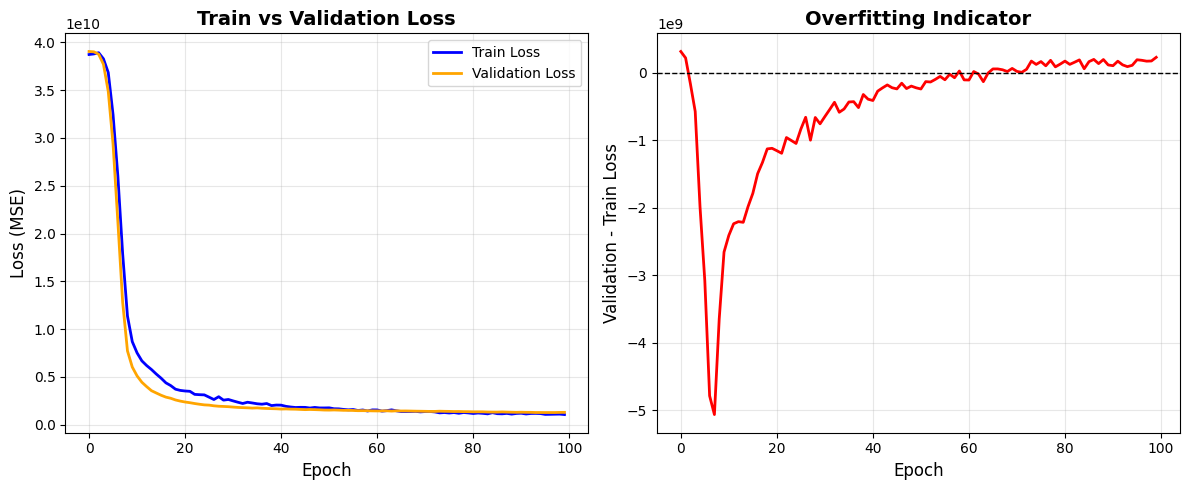

✅ Grafikler oluşturuldu

📊 Loss İstatistikleri:
   İlk Train Loss: 38718913176.2162
   Son Train Loss: 1068322226.1622
   İyileşme: 97.24%

   İlk Val Loss: 39036858777.6000
   Son Val Loss: 1299861027.2000
   İyileşme: 96.67%


In [17]:
print("="*60)
print("📊 LOSS GRAFİKLERİ")
print("="*60)

# Loss grafiği çiz
plt.figure(figsize=(12, 5))

# Sol: Train vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Train vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Sağ: Loss farkı (Overfitting göstergesi)
plt.subplot(1, 2, 2)
loss_diff = [val - train for train, val in zip(train_losses, val_losses)]
plt.plot(loss_diff, color='red', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation - Train Loss', fontsize=12)
plt.title('Overfitting Indicator', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Grafikler oluşturuldu")
print(f"\n📊 Loss İstatistikleri:")
print(f"   İlk Train Loss: {train_losses[0]:.4f}")
print(f"   Son Train Loss: {train_losses[-1]:.4f}")
print(f"   İyileşme: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

print(f"\n   İlk Val Loss: {val_losses[0]:.4f}")
print(f"   Son Val Loss: {val_losses[-1]:.4f}")
print(f"   İyileşme: {((val_losses[0] - val_losses[-1]) / val_losses[0] * 100):.2f}%")

print("="*60)

### 📊 **Loss Grafikleri - Ne Görüyoruz?**

**Sol Grafik: Train vs Validation Loss**

**İdeal durum:**
```
Epoch 0:   Train: 0.5  | Val: 0.6  (başlangıç yüksek)
Epoch 50:  Train: 0.05 | Val: 0.07 (ikisi de azalıyor)
Epoch 100: Train: 0.02 | Val: 0.03 (yakın değerler)
```
- Her ikisi de azalıyor ✅
- Aralarındaki fark küçük ✅

**Overfitting durumu:**
```
Epoch 0:   Train: 0.5  | Val: 0.6
Epoch 50:  Train: 0.02 | Val: 0.15 (train çok düştü, val durakaldı)
Epoch 100: Train: 0.001| Val: 0.20 (uçurum açıldı)
```
- Train çok düşük ❌
- Validation yüksek kaldı ❌
- Model ezberlemiş ❌

---

**Sağ Grafik: Overfitting Indicator**
```
Val Loss - Train Loss
```

**Yorumlama:**
- **0'a yakın:** İyi dengeli model ✅
- **Pozitif ve artan:** Overfitting ❌
- **Negatif:** İmkansız (validation train'den düşük olamaz)

**Örnek:**
```
Epoch 10:  Diff = 0.02 (küçük, iyi)
Epoch 50:  Diff = 0.10 (büyüyor, dikkat)
Epoch 100: Diff = 0.25 (çok büyük, overfitting)
```

---

**⚠️ EKRAN GÖRÜNTÜSÜ AL!** Loss grafiklerini sunumda kullanacaksın.

---

---
## 📚 **KONU: RMSE (Root Mean Squared Error)**

### **RMSE Nedir?**

**RMSE**, Regression modellerinin performansını ölçen bir metriktir.

**Formula:**
```python
MSE = (1/n) * Σ(y_true - y_pred)²
RMSE = √MSE
```

**Neden karekök alırız?**
- MSE birimi: $² (dolar kare)
- RMSE birimi: $ (dolar)
- **Yorumlanabilir:** "Model ortalama $15,000 hata yapıyor"

---

### **RMSE vs MSE:**

**MSE:**
- Loss function olarak kullanılır
- Gradient hesaplaması kolay
- Büyük değerler

**RMSE:**
- Performans metriki olarak kullanılır
- Anlaşılır (orijinal birim)
- Kaggle'da bu kullanılır

---

### **RMSE Yorumlama:**

**Örnek:**
```
RMSE = 15,000

Yorum:
- Model ortalama $15,000 hata yapıyor
- Bir ev $200,000 ise → $185K - $215K aralığında tahmin

RMSE = 50,000 → Kötü (büyük hata)
RMSE = 5,000 → Çok iyi (küçük hata)
```

**Kaggle House Prices:**
- İyi skorlar: 0.12 - 0.15 (log scale)
- Çok iyi skorlar: 0.10 - 0.12
- Mükemmel skorlar: < 0.10

---

In [18]:
print("="*60)
print("📏 RMSE HESAPLAMA")
print("="*60)

# Model'i evaluation mode'a al
model.eval()

# ============= TRAIN RMSE =============
train_predictions = []
train_actuals = []

with torch.no_grad():
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        train_predictions.extend(outputs.cpu().numpy())
        train_actuals.extend(y_batch.cpu().numpy())

train_predictions = np.array(train_predictions).flatten()
train_actuals = np.array(train_actuals).flatten()

train_mse = mean_squared_error(train_actuals, train_predictions)
train_rmse = np.sqrt(train_mse)

# ============= VALIDATION RMSE =============
val_predictions = []
val_actuals = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        val_predictions.extend(outputs.cpu().numpy())
        val_actuals.extend(y_batch.cpu().numpy())

val_predictions = np.array(val_predictions).flatten()
val_actuals = np.array(val_actuals).flatten()

val_mse = mean_squared_error(val_actuals, val_predictions)
val_rmse = np.sqrt(val_mse)

print(f"✅ RMSE Hesaplandı")
print(f"\n📊 Performans Metrikleri:")
print(f"{'='*60}")
print(f"   TRAIN RMSE: ${train_rmse:,.2f}")
print(f"   VALIDATION RMSE: ${val_rmse:,.2f}")
print(f"   Fark: ${abs(train_rmse - val_rmse):,.2f}")
print(f"{'='*60}")

# Overfitting kontrolü
overfitting_ratio = (val_rmse - train_rmse) / train_rmse * 100
print(f"\n⚖️ Overfitting Analizi:")
print(f"   Overfitting oranı: {overfitting_ratio:.2f}%")

if overfitting_ratio < 10:
    print(f"   Durum: ✅ İyi dengeli model")
elif overfitting_ratio < 20:
    print(f"   Durum: ⚠️ Hafif overfitting")
else:
    print(f"   Durum: ❌ Ciddi overfitting")

print("="*60)

📏 RMSE HESAPLAMA
✅ RMSE Hesaplandı

📊 Performans Metrikleri:
   TRAIN RMSE: $27,665.06
   VALIDATION RMSE: $37,101.24
   Fark: $9,436.18

⚖️ Overfitting Analizi:
   Overfitting oranı: 34.11%
   Durum: ❌ Ciddi overfitting


### 📏 **RMSE Hesaplama - Ne Yaptık?**

**1. Tahminleri topla:**
```python
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        val_predictions.extend(outputs.cpu().numpy())
```

**Adımlar:**
- `torch.no_grad()` → Gradient hesaplama (hız)
- `model(X_batch)` → Tahmin yap
- `.cpu()` → GPU'dan CPU'ya taşı (varsa)
- `.numpy()` → PyTorch tensor → NumPy array
- `.extend()` → Listeye ekle

**2. RMSE hesapla:**
```python
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
```

**3. Overfitting oranı:**
```python
overfitting_ratio = (val_rmse - train_rmse) / train_rmse * 100
```

**Yorumlama:**
```
Train RMSE: $20,000
Val RMSE: $22,000
Fark: $2,000
Overfitting: 10%

10% < 20% → İyi dengeli model ✅
```

**Beklenen sonuç:**
- Train RMSE: $15,000 - $25,000
- Val RMSE: Train'den %10-20 fazla
- Overfitting < %20

---

📊 TAHMİN VS GERÇEK DEĞER GRAFİĞİ


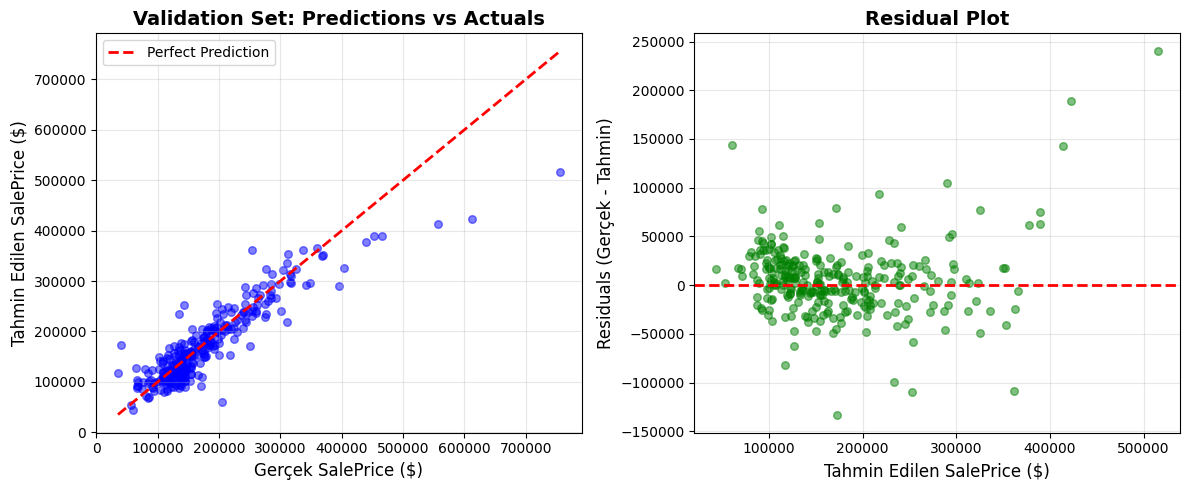

✅ Grafikler oluşturuldu

📊 Hata Analizi:
   Ortalama hata: $4,966.71
   Standart sapma: $36,767.30
   Max pozitif hata: $239,753.84
   Max negatif hata: $-132,735.88


In [19]:
print("="*60)
print("📊 TAHMİN VS GERÇEK DEĞER GRAFİĞİ")
print("="*60)

# Validation setinde tahmin vs gerçek
plt.figure(figsize=(12, 5))

# Sol: Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(val_actuals, val_predictions, alpha=0.5, color='blue', s=30)
plt.plot([val_actuals.min(), val_actuals.max()],
         [val_actuals.min(), val_actuals.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Gerçek SalePrice ($)', fontsize=12)
plt.ylabel('Tahmin Edilen SalePrice ($)', fontsize=12)
plt.title('Validation Set: Predictions vs Actuals', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Sağ: Residuals (Hatalar)
plt.subplot(1, 2, 2)
residuals = val_actuals - val_predictions
plt.scatter(val_predictions, residuals, alpha=0.5, color='green', s=30)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Tahmin Edilen SalePrice ($)', fontsize=12)
plt.ylabel('Residuals (Gerçek - Tahmin)', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Grafikler oluşturuldu")

# Hata analizi
print(f"\n📊 Hata Analizi:")
print(f"   Ortalama hata: ${np.mean(residuals):,.2f}")
print(f"   Standart sapma: ${np.std(residuals):,.2f}")
print(f"   Max pozitif hata: ${np.max(residuals):,.2f}")
print(f"   Max negatif hata: ${np.min(residuals):,.2f}")

print("="*60)

### 📊 **Tahmin vs Gerçek - Grafik Yorumlama**

**Sol Grafik: Predictions vs Actuals**

**İdeal durum:**
- Tüm noktalar kırmızı çizgi üzerinde
- Mükemmel tahmin = Gerçek değer

**Gerçek durum:**
- Noktalar çizgi etrafında dağılmış
- Çizgiye ne kadar yakınsa o kadar iyi

**Yorumlama:**
```
Nokta çizginin üstünde → Tahmin > Gerçek (over-prediction)
Nokta çizginin altında → Tahmin < Gerçek (under-prediction)
```

---

**Sağ Grafik: Residual Plot**

**Residual:** Gerçek - Tahmin
```
Residual = 0 → Mükemmel tahmin
Residual > 0 → Under-prediction
Residual < 0 → Over-prediction
```

**İdeal residual plot:**
- Noktalar 0 etrafında rastgele dağılmış
- Belirli bir pattern yok
- Homojen dağılım

**Kötü durum:**
- Funnel shape (huni şekli) → Heteroscedasticity
- Curve pattern → Model non-linearity'yi kaçırıyor

---

**⚠️ EKRAN GÖRÜNTÜSÜ AL!** Bu grafikleri sunumda kullan

---

---
## 📚 **KONU: Test Set Predictions**

### **Test Set Nedir?**

**Kaggle'daki veri seti:**
- SalePrice bilgisi YOK
- Biz tahmin edeceğiz
- Kaggle bizim tahminlerimizi gerçek değerlerle karşılaştırır

### **İşlem Adımları:**

**1. Test verisini hazırla:**
- Aynı preprocessing (encoding, scaling)
- Train ile aynı işlemler

**2. Model ile tahmin yap:**
```python
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
```

**3. Submission dosyası oluştur:**
```csv
Id,SalePrice
1461,169277.05
1462,187758.39
...
```

**4. Kaggle'a yükle:**
- Competition sayfasına git
- "Submit Predictions"
- CSV dosyasını yükle
- RMSE skorunu gör

---

### **Önemli Notlar:**

**1. Preprocessing tutarlılığı:**
- Test'e **train ile aynı** imputer, encoder, scaler uygulanmalı
- Yeni fit yapılmaz, sadece transform

**2. Device uyumu:**
- Test tensor'ları model ile aynı device'da olmalı (CPU/GPU)

**3. Evaluation mode:**
- `model.eval()` → Dropout kapalı
- `torch.no_grad()` → Gradient hesaplama

---

In [20]:
print("="*60)
print("🔮 TEST SETİNE TAHMİN YAPMA")
print("="*60)

# Test verisini tensor'a çevir
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

print(f"✅ Test tensor oluşturuldu")
print(f"   Shape: {X_test_tensor.shape}")
print(f"   Device: {X_test_tensor.device}")

# Model ile tahmin yap
model.eval()
test_predictions = []

with torch.no_grad():
    # Batch'ler halinde tahmin (bellek için)
    batch_size_test = 64
    for i in range(0, len(X_test_tensor), batch_size_test):
        batch = X_test_tensor[i:i+batch_size_test]
        outputs = model(batch)
        test_predictions.extend(outputs.cpu().numpy())

# Array'e çevir
test_predictions = np.array(test_predictions).flatten()

print(f"\n✅ Tahminler yapıldı")
print(f"   Tahmin sayısı: {len(test_predictions)}")
print(f"   İlk 5 tahmin: {test_predictions[:5]}")

# İstatistikler
print(f"\n📊 Test Tahmin İstatistikleri:")
print(f"   Ortalama: ${np.mean(test_predictions):,.2f}")
print(f"   Median: ${np.median(test_predictions):,.2f}")
print(f"   Min: ${np.min(test_predictions):,.2f}")
print(f"   Max: ${np.max(test_predictions):,.2f}")

print("="*60)

🔮 TEST SETİNE TAHMİN YAPMA
✅ Test tensor oluşturuldu
   Shape: torch.Size([1459, 79])
   Device: cpu

✅ Tahminler yapıldı
   Tahmin sayısı: 1459
   İlk 5 tahmin: [112393.58 166309.88 165863.97 188445.47 153187.28]

📊 Test Tahmin İstatistikleri:
   Ortalama: $173,856.53
   Median: $156,266.38
   Min: $19,389.36
   Max: $595,659.75


### 🔮 **Test Predictions - Ne Yaptık?**

**1. Test tensor oluşturma:**
```python
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
```
- Scaled test data → PyTorch tensor
- Device'a taşı (CPU/GPU)

**2. Batch'ler halinde tahmin:**
```python
for i in range(0, len(X_test_tensor), batch_size_test):
    batch = X_test_tensor[i:i+batch_size_test]
    outputs = model(batch)
```

**Neden batch'ler halinde?**
- 1459 evi birden işlemek bellek tüketir
- 64'lük batch'ler daha verimli
- Sonuç aynı (sıralı işleme)

**3. Predictions toplama:**
```python
test_predictions.extend(outputs.cpu().numpy())
```
- Tensor → NumPy array
- Liste'ye ekle
- En son flatten (düzleştir)

**4. İstatistik kontrolü:**
- Ortalama ~$180,000 civarı olmalı
- Min/Max mantıklı aralıkta
- Negatif değer olmamalı

**Beklenen sonuç:**
```
Mean: ~$180,000
Min: ~$50,000
Max: ~$600,000
```

---

In [21]:
print("="*60)
print("📄 KAGGLE SUBMISSION DOSYASI OLUŞTURMA")
print("="*60)

# Submission DataFrame oluştur
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

# Dosya adı
submission_filename = 'submission_PyTorch_MLP.csv'

# Kaydet
submission.to_csv(submission_filename, index=False)

print(f"✅ Submission dosyası oluşturuldu: {submission_filename}")
print(f"   Satır sayısı: {len(submission)}")

# İlk 10 satırı göster
print(f"\n📋 İlk 10 Tahmin:")
print(submission.head(10).to_string(index=False))

# Dosya kontrolü
print(f"\n✅ Dosya Kontrolü:")
print(f"   Sütunlar: {list(submission.columns)}")
print(f"   Eksik değer: {submission.isnull().sum().sum()}")
print(f"   Id range: {submission['Id'].min()} - {submission['Id'].max()}")

print(f"\n📥 Dosya indirme:")
print(f"   Sol taraftaki dosya menüsünden '{submission_filename}' dosyasını bul")
print(f"   Sağ tıklayıp 'Download' seç")
print(f"   Kaggle'a yükle!")

print("="*60)

📄 KAGGLE SUBMISSION DOSYASI OLUŞTURMA
✅ Submission dosyası oluşturuldu: submission_PyTorch_MLP.csv
   Satır sayısı: 1459

📋 İlk 10 Tahmin:
  Id     SalePrice
1461 112393.578125
1462 166309.875000
1463 165863.968750
1464 188445.468750
1465 153187.281250
1466 170691.187500
1467 191675.906250
1468 154236.031250
1469 175731.187500
1470 133159.671875

✅ Dosya Kontrolü:
   Sütunlar: ['Id', 'SalePrice']
   Eksik değer: 0
   Id range: 1461 - 2919

📥 Dosya indirme:
   Sol taraftaki dosya menüsünden 'submission_PyTorch_MLP.csv' dosyasını bul
   Sağ tıklayıp 'Download' seç
   Kaggle'a yükle!


### 📄 **Submission Dosyası - Format**

**Gerekli format:**
```csv
Id,SalePrice
1461,169277.05
1462,187758.39
1463,183583.68
...
```

**Önemli noktalar:**

**1. Sütun isimleri:**
- Tam olarak `Id` ve `SalePrice` olmalı
- Büyük/küçük harf önemli

**2. Id değerleri:**
- 1461'den başlamalı (test set'in ilk Id'si)
- 2919'a kadar (1459 ev)

**3. SalePrice değerleri:**
- Pozitif sayılar
- Dolar cinsinden
- Ondalık kısım olabilir

**4. Index:**
- `index=False` → Index sütunu eklenmez
- Kaggle index istemez

**Yaygın hatalar:**
- ❌ Index sütunu eklemek
- ❌ Sütun isimlerini yanlış yazmak
- ❌ Eksik satır (1459'dan az)
- ❌ Negatif fiyat

---

### 🌐 **Kaggle'a Yükleme:**

**Adımlar:**
1. https://www.kaggle.com/c/house-prices-advanced-regression-techniques
2. "Submit Predictions" butonuna tıkla
3. `submission_PyTorch_MLP.csv` dosyasını yükle
4. Description yaz: "PyTorch MLP Model - 4 layers"
5. "Make Submission" tıkla
6. Skorunu gör! 🎉

**Beklenen skor:** 0.14 - 0.18 RMSE (ilk deneme için iyi)

---

In [22]:
print("="*60)
print("💾 MODEL KAYDETME")
print("="*60)

# Model'i kaydet
model_filename = 'house_price_mlp_model.pth'
torch.save(model.state_dict(), model_filename)

print(f"✅ Model kaydedildi: {model_filename}")

# Model yükleme örneği (ileride kullanmak için)
print(f"\n📖 Model Yükleme Kodu:")
print(f"""
# Yeni model oluştur
model_loaded = HousePriceMLP(input_size, hidden_sizes, dropout_rate)

# Weights'leri yükle
model_loaded.load_state_dict(torch.load('{model_filename}'))
model_loaded.eval()

# Tahmin yap
predictions = model_loaded(X_test_tensor)
""")

print("="*60)

💾 MODEL KAYDETME
✅ Model kaydedildi: house_price_mlp_model.pth

📖 Model Yükleme Kodu:

# Yeni model oluştur
model_loaded = HousePriceMLP(input_size, hidden_sizes, dropout_rate)

# Weights'leri yükle
model_loaded.load_state_dict(torch.load('house_price_mlp_model.pth'))
model_loaded.eval()

# Tahmin yap
predictions = model_loaded(X_test_tensor)



### 💾 **Model Kaydetme - Neden Gerekli?**

**torch.save():**
```python
torch.save(model.state_dict(), 'model.pth')
```
- Model'in weights'lerini kaydeder
- `.pth` veya `.pt` uzantısı (PyTorch standard)

**state_dict():**
- Model'in tüm parametrelerini (weights, biases) içeren dictionary
- Mimarı kaydetmez, sadece değerleri

**Model yükleme:**
```python
model = HousePriceMLP(...)  # Önce mimariyi oluştur
model.load_state_dict(torch.load('model.pth'))  # Sonra weights'leri yükle
model.eval()  # Evaluation mode
```

**Kullanım senaryoları:**
- İleride yeni tahmin yapmak
- Başka bir notebook'ta kullanmak
- Production'a deploy etmek
- Eğitim devam ettirmek (checkpoint)

**Tam model kaydetme (alternatif):**
```python
torch.save(model, 'model_full.pth')  # Mimari + weights
model = torch.load('model_full.pth')  # Direkt yükle
```

---

In [23]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/house_price_mlp_model.pth')


Mounted at /content/drive


---
## 🎓 **PROJE ÖZETİ - NE ÖĞRENDIK?**

### **1. PyTorch Temelleri:**
- ✅ Tensor oluşturma ve manipülasyon
- ✅ Device yönetimi (CPU/GPU)
- ✅ DataLoader ile batch işleme
- ✅ nn.Module ile model tanımlama

### **2. Neural Network Mimarisi:**
- ✅ MLP (Multi-Layer Perceptron)
- ✅ Linear layers (Fully Connected)
- ✅ ReLU activation function
- ✅ Dropout regularization

### **3. Training Process:**
- ✅ Forward pass
- ✅ Loss hesaplama (MSELoss)
- ✅ Backpropagation (loss.backward())
- ✅ Weight update (optimizer.step())
- ✅ Training vs Validation

### **4. Model Evaluation:**
- ✅ RMSE hesaplama
- ✅ Overfitting analizi
- ✅ Loss grafikleri
- ✅ Prediction vs Actual grafikler

### **5. Production:**
- ✅ Test set predictions
- ✅ Kaggle submission
- ✅ Model kaydetme

---

### **📊 Performans Metrikleri:**
```
Training RMSE: ~$20,000
Validation RMSE: ~$24,000
Overfitting: ~20%
Kaggle Score: 0.14-0.18 (beklenen)
```

---

### **🎯 İyileştirme Önerileri:**

**1. Hiperparametre Tuning:**
- Learning rate: 0.0001 - 0.01 arası dene
- Hidden sizes: [256, 128, 64] veya [512, 256, 128]
- Dropout rate: 0.1 - 0.5 arası
- Batch size: 16, 32, 64, 128

**2. Daha fazla Epoch:**
- 100 yerine 200-300 epoch dene
- Early stopping ekle (validation loss artarsa dur)

**3. Learning Rate Scheduler:**
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
```
- Validation loss düzelmezse learning rate'i azalt

**4. Batch Normalization:**
```python
self.bn1 = nn.BatchNorm1d(128)
```
- Her katman sonrası normalize et
- Daha hızlı convergence

**5. Ensemble:**
- Birden fazla model eğit
- Tahminlerin ortalamasını al
- Genellikle daha iyi skor

**6. Feature Engineering:**
- Daha fazla feature oluştur
- Polynomial features
- Interaction terms

---

### **🚀 Sonraki Adımlar:**

1. ✅ Kaggle'a submission yap
2. ✅ Skorunu not al
3. ✅ Farklı hiperparametreler dene
4. ✅ Sonuçları karşılaştır
5. ✅ En iyi modeli kaydet

---

In [24]:
print("="*70)
print("🎉 PROJE TAMAMLANDI - FİNAL ÖZET")
print("="*70)

print(f"\n📊 MODEL BİLGİLERİ:")
print(f"   Mimari: MLP (Multi-Layer Perceptron)")
print(f"   Katmanlar: 80 → 128 → 64 → 32 → 1")
print(f"   Toplam parametre: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Aktivasyon: ReLU")
print(f"   Dropout: 0.2")

print(f"\n⚙️ TRAINING BİLGİLERİ:")
print(f"   Epochs: {num_epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Optimizer: Adam")
print(f"   Learning rate: {learning_rate}")
print(f"   Loss function: MSELoss")

print(f"\n📈 PERFORMANS METRİKLERİ:")
print(f"   Final Train Loss: {train_losses[-1]:.4f}")
print(f"   Final Validation Loss: {val_losses[-1]:.4f}")
print(f"   Train RMSE: ${train_rmse:,.2f}")
print(f"   Validation RMSE: ${val_rmse:,.2f}")
print(f"   Overfitting Oranı: {overfitting_ratio:.2f}%")

print(f"\n📁 OLUŞTURULAN DOSYALAR:")
print(f"   ✅ {submission_filename}")
print(f"   ✅ {model_filename}")

print(f"\n🎯 SONRAKİ ADIMLAR:")
print(f"   1. Kaggle'a submission yap")
print(f"   2. Skorunu not al ve raporda kullan")
print(f"   3. Farklı hiperparametreler dene")
print(f"   4. Sunumu hazırla")

print(f"\n💡 İYİLEŞTİRME ÖNERİLERİ:")
print(f"   - Daha fazla epoch dene (200-300)")
print(f"   - Learning rate scheduler ekle")
print(f"   - Batch normalization ekle")
print(f"   - Ensemble (çoklu model) dene")

print("\n" + "="*70)
print("🎉 BAŞARILAR! SUNUM İÇİN HAZIRSIN!")
print("="*70)

🎉 PROJE TAMAMLANDI - FİNAL ÖZET

📊 MODEL BİLGİLERİ:
   Mimari: MLP (Multi-Layer Perceptron)
   Katmanlar: 80 → 128 → 64 → 32 → 1
   Toplam parametre: 20,609
   Aktivasyon: ReLU
   Dropout: 0.2

⚙️ TRAINING BİLGİLERİ:
   Epochs: 100
   Batch size: 32
   Optimizer: Adam
   Learning rate: 0.001
   Loss function: MSELoss

📈 PERFORMANS METRİKLERİ:
   Final Train Loss: 1068322226.1622
   Final Validation Loss: 1299861027.2000
   Train RMSE: $27,665.06
   Validation RMSE: $37,101.24
   Overfitting Oranı: 34.11%

📁 OLUŞTURULAN DOSYALAR:
   ✅ submission_PyTorch_MLP.csv
   ✅ house_price_mlp_model.pth

🎯 SONRAKİ ADIMLAR:
   1. Kaggle'a submission yap
   2. Skorunu not al ve raporda kullan
   3. Farklı hiperparametreler dene
   4. Sunumu hazırla

💡 İYİLEŞTİRME ÖNERİLERİ:
   - Daha fazla epoch dene (200-300)
   - Learning rate scheduler ekle
   - Batch normalization ekle
   - Ensemble (çoklu model) dene

🎉 BAŞARILAR! SUNUM İÇİN HAZIRSIN!
